In [ ]:
using Statistics 
using Plots

function wrap_index(i::Int, l::Int)::Int
    wrap = (i - 1) % l + 1
    return (wrap <= 0) ? l + wrap : wrap
end

mutable struct Ising2D
    l::Int 
    n::Int 
    temperature::Float64
    w::Vector{Float64} # Boltzmann weights
    state::Matrix 
    energy::Int
    magnetization::Int
    mc_steps::Int 
    accepted_moves::Int 
    energy_array::Vector{Int}
    magnetization_array::Vector{Int}
end 

Ising2D(l::Int, temperature::Float64)
    n = l^2 
    w = zeros(9)
    w[9] = exp(-8.0 / temperature)
    w[5] = exp(-4.0 / temperature)
    state = ones(Int, l, l) # initially all spins up
    energy = -2 * n
    magnetization = n
    return Ising2D(l, n, temperature, w, state, energy, magnetization, 0, 0, Int[], Int[])
end

function reset!(ising::Ising2D)
    ising.mc_steps = 0 
    ising.accepted_moves = 0 
    ising.energy_array = Int[] 
    ising.magnetization_array = Int[] 
end

function mc_step!(ising::Ising2D) 
    l::Int = ising.l 
    n::Int = ising.n 
    w = ising.w 

    state = ising.state 
    accepted_moves = ising.accepted_moves
    energy = ising.energy 
    magnetization = ising.magnetization

    random_positions = l * rand(2 * n)
    random_array = rand(n) 

    for k in 1:n
        i = trunc(Int, random_positions[2 * k - 1]) + 1 
        j = trunc(Int, random_positions[2 * k]) + 1 

        de = 2 * state[i, j] * (state[i % l + 1, j] + state[wrap_index(i - 1, l), j] 
            + state[i, j % l + 1] + state[i, wrap_index(j - 1, l)])

        if de <= 0 || w[de + 1] > random_array[k]
            accepted_moves += 1 
            new_spin = - state[i, j] # flip spin
            state[i, j] = new_spin 
            energy += de 
            magnetization += 2 * new_spin
        end

    end

    ising.state = state 
    ising.accepted_moves = accepted_moves
    ising.energy = energy 
    ising.magnetization = magnetization 

    append!(ising.energy_array, ising.energy) 
    append!(ising.magnetization_array, ising.magnetization)
    ising.mc_steps = ising.mc_steps + 1
end

function steps!(ising::Ising2D, num::Int=100)
	for i in 1:num
		mc_step!(ising)
	end 
end

function mean_energy(ising::Ising2D)
	return mean(ising.energy_array) / ising.n
end 

function specific_heat(ising::Ising2D)
	return (std(ising.energy_array) / ising.temperature) ^ 2 / ising.n
end

function mean_magnetization(ising::Ising2D)
	return mean(ising.magnetization_array) / ising.n
end

function susceptibility(ising::Ising2D)
	return (std(ising.magnetization_array)) ^ 2 / (ising.temperature * ising.n)	
end

function observables(ising::Ising2D)
	printstyled("Temperature\t\t", bold=true)
	print(ising.temperature); print("\n")

	printstyled("Mean Energy\t\t", bold=true)
	print(mean_energy(ising)); print("\n")

	printstyled("Mean Magnetiz.\t\t", bold=true)
	print(mean_magnetization(ising)); print("\n")

	printstyled("Specific Heat\t\t", bold=true)
	print(specific_heat(ising)); print("\n")

	printstyled("Susceptibility\t\t", bold=true)
	print(susceptibility(ising)); print("\n")

	printstyled("MC Steps\t\t", bold=true)
	print(ising.mc_steps); print("\n")
	printstyled("Accepted Moves\t\t", bold=true)
	print(ising.accepted_moves); print("\n")
end

function plot_ising(state::Matrix{Int})
	pos = Tuple.(findall(>(0), state))
	neg = Tuple.(findall(<(0), state))
	scatter(pos, markersize=5)
	scatter!(neg, markersize=5)
end


Temperature		2.3
Mean Energy		-1.396875
Mean Magnetiz.		0.656333984375
Specific Heat		1.6356857802982578
Susceptibility		4.500708505720394
MC Steps		1000
Accepted Moves		211605


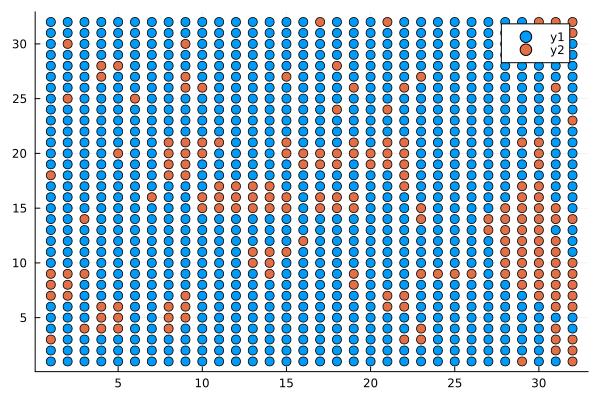

In [7]:
m = Ising2D(32, 2.3)
steps!(m, 1000)
observables(m)
plot_ising(m.state)